In [2]:
from typing import List, Tuple
from pathlib import Path


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm
tqdm.tqdm.pandas()

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
from market_data import MarketData

In [4]:
trading_days_per_year = 252

# Pair selection criteria
- Acceptable volatility
- Pass stationary test
- Spread is stationary
- High Cointegration's p-value
- High correlation
- Low Half life
- High number of reversion
- High magnitude of spread
- mean reversion (Hurst exponent)
- Mature asset (age more than 5 years)
- VaR

# Cointegration

In [7]:
cointegration_df = pd.read_csv('analysis/cointegration_log_price.csv')
cointegration_df


,left_symbol,right_symbol,cointegration,cointegration_test_period
0,USDNZD,USDJPY,0.785850,4110
1,USDNZD,HKDUSD,0.505716,4053
2,USDNZD,USDHKD,0.466705,4057
3,USDNZD,USDGBP,0.922822,4062
4,USDNZD,USDEUR,0.920139,3320
...,...,...,...,...
556,NOKUSD,USDSGD,0.921989,3979
557,NOKUSD,AUDUSD,0.989823,4076
558,USDSEK,USDSGD,0.825440,3936
559,USDSEK,AUDUSD,0.827390,3912


In [8]:
min_test_year = 5
cointegration_df = cointegration_df[cointegration_df['cointegration_test_period'] >= min_test_year * trading_days_per_year]
cointegration_df

,left_symbol,right_symbol,cointegration,cointegration_test_period
0,USDNZD,USDJPY,0.785850,4110
1,USDNZD,HKDUSD,0.505716,4053
2,USDNZD,USDHKD,0.466705,4057
3,USDNZD,USDGBP,0.922822,4062
4,USDNZD,USDEUR,0.920139,3320
...,...,...,...,...
556,NOKUSD,USDSGD,0.921989,3979
557,NOKUSD,AUDUSD,0.989823,4076
558,USDSEK,USDSGD,0.825440,3936
559,USDSEK,AUDUSD,0.827390,3912


In [9]:
cointegration_df

,left_symbol,right_symbol,cointegration,cointegration_test_period
0,USDNZD,USDJPY,0.785850,4110
1,USDNZD,HKDUSD,0.505716,4053
2,USDNZD,USDHKD,0.466705,4057
3,USDNZD,USDGBP,0.922822,4062
4,USDNZD,USDEUR,0.920139,3320
...,...,...,...,...
556,NOKUSD,USDSGD,0.921989,3979
557,NOKUSD,AUDUSD,0.989823,4076
558,USDSEK,USDSGD,0.825440,3936
559,USDSEK,AUDUSD,0.827390,3912


In [10]:
cointegration_df.sort_values('cointegration', ascending=False, inplace=True)

/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_51750/4089212689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cointegration_df.sort_values('cointegration', ascending=False, inplace=True)


In [11]:
cointegration_df

,left_symbol,right_symbol,cointegration,cointegration_test_period
291,SGDUSD,USDCNY,1.000000,3369
285,SGDUSD,GBPUSD,1.000000,3900
301,SGDUSD,USDDKK,1.000000,2252
300,SGDUSD,CNYUSD,1.000000,3694
299,SGDUSD,INRUSD,1.000000,3906
...,...,...,...,...
267,JPYUSD,CHFUSD,0.019865,4056
261,JPYUSD,SGDUSD,0.016562,3926
41,USDJPY,SGDUSD,0.016279,3932
271,JPYUSD,XAGUSD,0.008613,2746


In [9]:
profile_df = pd.read_parquet('dataset/us_stock/profile.parquet')
profile_df

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,cik,isin,cusip,exchange,exchangeShortName,industry,website,description,ceo,sector,country,fullTimeEmployees,phone,address,city,state,zip,dcfDiff,dcf,image,ipoDate,defaultImage,isEtf,isActivelyTrading,isAdr,isFund
0,MMM,116.81,0.986735,9717346,64667652096,5.95,107.07-186.3,3.699997,3M Company,USD,0000066740,US88579Y1010,88579Y101,New York Stock Exchange,NYSE,Conglomerates,https://www.3m.com,3M Company operates as a diversified technolog...,Mr. Michael Roman,Industrials,US,95000,16517331474,"3M Center, Bldg. 220-13E-26A",Saint Paul,MINNESOTA,55144-1000,7.79771,124.6080,https://financialmodelingprep.com/image-stock/...,1946-01-14,False,False,True,False,False
1,AOS,50.13,1.208548,1045389,7742478336,1.12,46.58-86.74,1.370003,A. O. Smith Corporation,USD,0000091142,US8318652091,831865209,New York Stock Exchange,NYSE,Specialty Industrial Machinery,https://www.aosmith.com,A. O. Smith Corporation manufactures and marke...,Mr. Kevin Wheeler,Industrials,US,13700,14143594000,11270 W Park Pl,Milwaukee,WISCONSIN,53224-9508,2.72625,52.8563,https://financialmodelingprep.com/image-stock/...,1994-12-14,False,False,True,False,False
2,ABT,95.06,0.709285,5323529,166470959104,1.88,93.25-142.6,-0.150002,Abbott Laboratories,USD,0000001800,US0028241000,002824100,New York Stock Exchange,NYSE,Medical Devices,https://www.abbott.com,"Abbott Laboratories, together with its subsidi...",Mr. Robert Ford,Healthcare,US,113000,12246676100,100 Abbott Park Rd,ABBOTT PARK,ILLINOIS,60064-6400,5.48656,100.5470,https://financialmodelingprep.com/image-stock/...,1937-03-01,False,False,True,False,False
3,ABBV,147.06,0.647383,5405496,260016783360,5.64,107.75-175.91,4.130005,AbbVie Inc.,USD,0001551152,US00287Y1091,00287Y109,New York Stock Exchange,NYSE,Drug Manufacturers—General,https://www.abbvie.com,"AbbVie Inc. discovers, develops, manufactures,...",Mr. Richard Gonzalez,Healthcare,US,50000,18479327900,1 N Waukegan Rd,North Chicago,ILLINOIS,60064-6400,5.52139,152.5810,https://financialmodelingprep.com/image-stock/...,2013-01-02,False,False,True,False,False
4,ABMD,256.22,1.314296,271576,11647991808,0.00,219.85-379.3,3.710007,"Abiomed, Inc.",USD,0000815094,US0036541003,003654100,NASDAQ Global Select,NASDAQ,Medical Devices,https://www.abiomed.com,"Abiomed, Inc. engages in the research, develop...",Mr. Michael Minogue,Healthcare,US,2003,19787775410,22 CHERRY HILL DR,Danvers,MASSACHUSETTS,01923,2.89484,259.1150,https://financialmodelingprep.com/image-stock/...,1987-07-29,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,CRUS,67.80,1.006263,467129,3792759296,0.00,61.94-95.84,2.330002,"Cirrus Logic, Inc.",USD,0000772406,US1727551004,172755100,NASDAQ Global Select,NASDAQ,Semiconductors,https://www.cirrus.com,"Cirrus Logic, Inc., a fabless semiconductor co...",Dr. Jason Rhode,Technology,US,1591,15128514000,800 W 6th St,Austin,TEXAS,78701,6.25288,74.0529,https://financialmodelingprep.com/image-stock/...,1989-06-09,False,False,True,False,False
726,RPM,88.73,0.938835,606259,11454954496,1.62,74.56-101.48,2.110001,RPM International Inc.,USD,0000110621,US7496851038,749685103,New York Stock Exchange,NYSE,Specialty Chemicals,https://www.rpminc.com,"RPM International Inc. manufactures, markets, ...",Mr. Frank Sullivan,Basic Materials,US,16751,13302735090,"2628 Pearl Rd, PO Box 777",Medina,OHIO,44258,1.91352,90.6435,https://financialmodelingprep.com/image-stock/...,1998-01-09,False,False,True,False,False
727,OSI,9.80,0.000000,9907,281750016,0.00,9.63-10.0,0.000000,Osiris Acquisition Corp.,USD,0001832136,None,None,New York Stock Exchange,NYSE,Shell Companies,https://osirisacquisitioncorp.com,Osiris Acquisition Corp. does not have signifi...,Mr. Benjamin E. Black,Financial Services,US,,646 993 4635,95 5th Avenue,New York,NY,10003,NaN,0.0000,https://financialmodelingprep.com/image-stock/...

# Correlation

In [10]:
corr_pair_df = pd.read_csv('analysis/correlation_pair.csv')
corr_pair_df

,left_symbol,right_symbol,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry
0,TX,TX,1.000000,Ternium S.A.,Basic Materials,Steel,Ternium S.A.,Basic Materials,Steel,True,True
1,EA,EA,1.000000,Electronic Arts Inc.,Communication Services,Electronic Gaming & Multimedia,Electronic Arts Inc.,Communication Services,Electronic Gaming & Multimedia,True,True
2,EBAY,EBAY,1.000000,eBay Inc.,Consumer Cyclical,Internet Retail,eBay Inc.,Consumer Cyclical,Internet Retail,True,True
3,SWKS,SWKS,1.000000,"Skyworks Solutions, Inc.",Technology,Semiconductors,"Skyworks Solutions, Inc.",Technology,Semiconductors,True,True
4,ECL,ECL,1.000000,Ecolab Inc.,Basic Materials,Specialty Chemicals,Ecolab Inc.,Basic Materials,Specialty Chemicals,True,True
...,...,...,...,...,...,...,...,...,...,...,...
451309,KHC,VRSN,-0.925933,The Kraft Heinz Company,Consumer Defensive,Packaged Foods,"VeriSign, Inc.",Technology,Software—Infrastructure,False,False
451310,NXPI,DO,-0.926678,NXP Semiconductors N.V.,Technology,Semiconductors,"Diamond Offshore Drilling, Inc.",Energy,Oil & Gas Drilling,False,False
451311,DO,NXPI,-0.926678,"Diamond Offshore Drilling, Inc.",Energy,Oil & Gas Drilling,NXP Semiconductors N.V.,Technology,Semiconductors,False,False
451312,SLB,ASND,-0.932157,Schlumberger Limited,Energy,Oil & Gas Equipment & Services,Ascendis Pharma A/S,Healthcare,Biotechnology,False,False


# Market Data

In [11]:
market_data = MarketData('dataset')


In [12]:
symbols = pd.concat([cointegration_df['left_symbol'], cointegration_df['right_symbol']]).drop_duplicates()
symbols

172088    META
90276      DVA
142218    HBAN
10817     AKAM
134526     HIG
          ... 
252093    CNXT
242979     GME
247803      WB
252401     RPM
74498       TX
Length: 662, dtype: object

In [13]:
price_df = market_data.read_batch(symbols)
price_df

100%|██████████| 662/662 [00:05<00:00, 113.26it/s]


,META,DVA,HBAN,AKAM,HIG,CB,CAG,CTRA,AFL,AMT,BDX,EQIX,BRK-B,LYB,GOOGL,GOOG,MO,LH,MCHP,DHR,ATVI,COF,LHX,WRB,ICE,CCI,NYT,GLW,AIG,HSIC,CSGP,SLB,EBAY,DUK,KMX,ACN,BKNG,JNJ,CHD,DGX,DOV,PEP,NEE,NVR,TER,WTW,DRI,ALGN,C,CMS,COO,CNC,RMD,AME,SPGI,APD,AWK,HUM,USB,TXN,CL,RE,MAR,CSCO,MBI,ON,CSX,BALL,TJX,BIO,WMT,ANSS,AMGN,NOW,BLK,MGM,DFS,CCK,JNPR,JPM,GPN,CPRT,ECL,CBOE,RTX,ELV,LOW,ES,LSXMA,COST,TT,PSA,CLX,BIIB,NFLX,ADI,FISV,AIZ,BF-B,KEY,D,IDXX,CMCSA,TDY,MTD,NKE,PNC,STZ,TDG,ABMD,AMZN,LNT,K,APH,TMO,MTB,FDS,JBHT,MLM,GD,TYL,DTE,MRK,CMI,BAC,AEP,NVDA,MSFT,HON,J,EMN,PKG,AAP,RF,ADM,MA,EXPD,MPWR,PAYC,ETN,PH,AZO,A,HST,IRM,RSG,PFG,AIV,PKI,O,ITW,GS,LAMR,L,OKE,LRCX,IBM,WEC,AVB,KLAC,FBHS,DHI,ZION,DE,BBY,ATO,PEG,HPE,GRMN,BHF,TXT,INTU,FIS,FITB,MTCH,CVS,CPB,LIN,BRO,IEX,NRG,JKHY,PPL,MPC,PTC,NWSA,MDLZ,CTSH,OMC,GL,ED,SHW,KO,NTRS,AJG,MOH,ADSK,BMY,MAS,NLOK,MET,NDAQ,APA,HRL,ADBE,STLD,SJM,AOS,ORCL,CE,ARE,CDNS,PG,TFC,MKTX,ABC,HP,SYY,DISH,SYK,POOL,BWA,EVRG,EW,DD,MKC,ORLY,ESS,FAST,ABT,RHI,ETSY,WFC,NDSN,PXD,EFX,PM,MMC,UPS,EPAM,TRV,CBRE,NWS,CME,MAA,FFIV,SEE,MMM,HOLX,CAT,CINF,APTV,LLL,AEE,PRU,LYV,PAYX,STR,BR,NSC,EIX,PCAR,ADP,CI,RCL,TSCO,TECH,WOR,SIVB,GILD,MCO,EMR,STE,FRT,ODFL,WBA,FE,FRC,DPZ,AON,ROST,WM,ZBH,EOG,OXY,PHM,LUMN,VRTX,LILAK,WAT,NTAP,ETR,CTLT,DLTR,CHRW,DXCM,KMB,AXP,OI,CIEN,INCY,CDW,TAP,ZBRA,ALB,ALLE,SO,MDT,BTU,CRL,MSCI,LNC,UHS,IR,WHR,AMAT,BAX,BEN,PNW,TSN,ABBV,HD,AVGO,CTAS,BKR,IQV,NBR,MU,SBNY,SBAC,PGR,UDR,AAPL,VICI,AMD,IFF,WU,BMRN,SCHW,HWM,UNH,FDX,RJF,QCOM,SII,UNP,CRM,AMCR,X,PPG,SNA,GNW,CNP,MHK,ZTS,LDOS,JBL,YUM,TGT,NLSN,GM,PEAK,XRAY,EXPE,MUR,GNTX,URI,TEL,ROP,VRSN,TPR,RYAAY,AMP,SBUX,EXR,NOC,ALL,DG,FLEX,HAS,TSLA,GPC,WDAY,FTV,DELL,TRGP,SRE,FL,DIS,STT,SGEN,KMI,REGN,ISRG,EL,INFY,ILMN,AVY,GIS,JCI,VRSK,FMC,PSX,SNPS,ALK,CHTR,PLD,CPWR,TTWO,KEYS,DLR,HLT,HSY,RIG,AES,CPT,PNR,WELL,ITT,ROK,HCA,FLR,IT,TROW,F,MNST,EXC,LMT,EQR,UNM,CZR,SE,XRX,ULTA,LKQ,SLM,V,ROL,ANET,FTNT,AZN,IPG,RL,KDP,KSS,INTC,SEDG,MCD,QMCO,AEO,RAD,M,NI,PANW,MELI,KBH,XEL,BSX,VMC,SWKS,VTR,CTXS,LSI,NWL,LUV,NCLH,PRGO,BA,LW,TFX,PDCO,MSI,LILA,AAL,KIM,LIFE,IP,SPG,BXP,MS,NXPI,LEG,ASML,WDC,BIG,CVX,MOS,T,REG,CMA,FLT,LVS,CAH,MCK,PENN,INVH,ATI,NOV,AMG,CFG,WY,STX,DVN,CNX,FWONA,WST,SANM,COTY,FLS,HES,LEN,DAL,DXC,UAL,HOG,HPQ,BK,PCG,VRTS,TRMB,PFE,NUE,XYL,BC,CNET,GPS,PVH,KR,SWK,CERN,CPRI,HII,SIRI,XLNX,VLO,SYF,WYNN,KHC,COP,AYI,EA,QGEN,EYE,MRO,HAL,NAVI,GWW,ODP,FCX,IVZ,CBRL,WAB,IAC,SPLK,URBN,VZ,WMB,PBCT,VTRS,QRVO,FANG,TRIP,PYPL,JEF,TEAM,IGT,THC,ENPH,AN,TEVA,EQT,CHKP,CMG,BB,LSXMK,WBD,XOM,ANF,TWTR,JWN,LLY,NEM,WRK,CLF,TMUS,GNRC,VNO,RNWK,PWR,MRVL,SUN,FB,INFO,NTES,R,BATRA,HFC,AA,UAA,BATRK,MMI,SRCL,LBTYK,FWONK,MAT,NCR,BBBY,FTI,FSLR,VFC,RRC,GE,BBWI,GHC,GT,FHN,GOLD,LULU,PARA,CF,TDC,LBTYA,TGNA,PBI,HBI,SLG,TCOM,LOGI,PTEN,RRD,PRDO,MAC,CCL,COMS,HRB,CNTO,VIAV,SIG,ADTN,IPGP,VOD,FOSL,JD,SWN,STCN,BIDU,USL,OKTA,QRTEA,ASND,ERIC,AM,NKTR,ENDP,CRUS,VEON,DIGI,CNXT,GME,WB,RPM,TX
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-02,NaN,9.0417,27.610819,NaN,46.15625,31.645832,25.826847,1.583333,6.273438,NaN,24.390244,NaN,30.58,NaN,NaN,NaN,45.3125,4.53125,4.444444,5.923048,1.359375,18.083332,21.257999,3.764060,NaN,NaN,32.71875,12.791667,783.111084,6.9118,NaN,40.34375,NaN,48.158665,4.78125,NaN,NaN,32.53125,2.375000,4.281250,24.048290,36.0000,7.398438,22.3125,16.87500,NaN,7.039463,NaN,267.500,43.8750,20.18750,NaN,1.750000,3.916667,18.031250,38.650555,NaN,21.1250,18.791668,11.953125,18.312500,40.500,30.91,9.677083,44.625000,NaN,2.986111,2.207031,2.066

# Pre-Selection

- Cointegration

In [14]:
pair_df = cointegration_df.merge(corr_pair_df, on=['left_symbol', 'right_symbol'], how='left')
pair_df


,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry
0,META,FB,1.0,2543,1.000000,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,"Meta Platforms, Inc.",Communication Services,Internet Content & Information,True,True
1,DVA,EQIX,1.0,5590,0.868073,DaVita Inc.,Healthcare,Medical Care Facilities,"Equinix, Inc.",Real Estate,REIT—Specialty,False,False
2,HBAN,KEY,1.0,6248,0.950604,Huntington Bancshares Incorporated,Financial Services,Banks—Regional,KeyCorp,Financial Services,Banks—Regional,True,True
3,DVA,ILMN,1.0,5600,0.886363,DaVita Inc.,Healthcare,Medical Care Facilities,"Illumina, Inc.",Healthcare,Diagnostics & Research,True,False
4,AKAM,LKQ,1.0,4802,0.848308,"Akamai Technologies, Inc.",Technology,Software—Infrastructure,LKQ Corporation,Consumer Cyclical,Auto Parts,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218725,AVB,VNO,0.0,6248,0.605664,"AvalonBay Communities, Inc.",Real Estate,REIT—Residential,Vornado Realty Trust,Real Estate,REIT—Office,True,False
218726,WRB,PARA,0.0,4255,0.288535,W. R. Berkley Corporation,Financial Services,Insurance—Property & Casualty,Paramount Global,Communication Services,Entertainment,False,False
218727,DE,HBI,0.0,4066,0.193961,Deere & Company,Industrials,Farm & Heavy Construction Machinery,Hanesbrands Inc.,Consumer Cyclical,Apparel Manufacturing,False,False
218728,COST,VNO,0.0,6248,0.068183,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,Vornado Realty Trust,Real Estate,REIT—Office,False,False


In [15]:

selected_pair_df = pair_df[
    (pair_df['cointegration'] > 0.95)
    & (~np.isclose(pair_df['cointegration'], 1.0))
]

selected_pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry
160,ICE,ZBRA,0.999990,4267,0.921816,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,Zebra Technologies Corporation,Technology,Communication Equipment,False,False
161,JNPR,TPR,0.999990,5551,-0.123542,"Juniper Networks, Inc.",Technology,Communication Equipment,"Tapestry, Inc.",Consumer Cyclical,Luxury Goods,False,False
162,MBI,LULU,0.999989,3843,-0.027899,MBIA Inc.,Financial Services,Insurance—Specialty,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,False,False
163,EBAY,LSI,0.999989,6065,0.914633,eBay Inc.,Consumer Cyclical,Internet Retail,"Life Storage, Inc.",Real Estate,REIT—Industrial,False,False
164,JPM,WTW,0.999989,5381,0.948272,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,Willis Towers Watson Public Limited Company,Financial Services,Insurance Brokers,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,BWA,LBTYK,0.950007,4316,0.875707,BorgWarner Inc.,Consumer Cyclical,Auto Parts,Liberty Global plc,Communication Services,Telecom Services,False,False
22691,LIN,SO,0.950006,6248,0.923458,Linde plc,Basic Materials,Specialty Chemicals,The Southern Company,Utilities,Utilities—Regulated Electric,False,False
22692,KR,PPG,0.950005,6248,0.901057,The Kroger Co.,Consumer Defensive,Grocery Stores,"PPG Industries, Inc.",Basic Materials,Specialty Chemicals,False,False
22693,DHI,ETSY,0.950004,1900,0.925374,"D.R. Horton, Inc.",Consumer Cyclical,Residential Construction,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False


# Spread 

In [16]:
def calculate_alpha_beta(left_prices: pd.Series, right_prices: pd.Series) -> Tuple[float]:
    # log prices
    left_prices = np.log(left_prices)
    right_prices = np.log(right_prices)


    regressor = LinearRegression()
    regressor.fit(left_prices.values.reshape(-1, 1), right_prices.values.reshape(-1, 1))
    
    alpha = regressor.intercept_[0]
    beta = regressor.coef_[0][0]
    
    return alpha, beta

In [17]:
def calculate_adjusted_price(prices: pd.Series, alpha: float, beta: float, return_log_price: bool = False) -> pd.Series:
    log_prices = np.log(prices)
    adjusted_log_prices = (alpha + beta * log_prices)
    if return_log_price:
        return adjusted_log_prices
    else:
        return np.exp(adjusted_log_prices)

In [18]:
def create_alpha_beta(pair: pd.Series) -> dict:

    left_symbol = pair['left_symbol']
    right_symbol = pair['right_symbol']

    df = price_df[[left_symbol, right_symbol]].dropna(how='any')

    left_prices = df[left_symbol]
    right_prices = df[right_symbol]

    alpha, beta = calculate_alpha_beta(left_prices, right_prices)

    return {'alpha': alpha, 'beta': beta}

In [19]:

selected_pair_df[['alpha', 'beta']] = selected_pair_df.progress_apply(create_alpha_beta, axis=1, result_type='expand')
selected_pair_df

100%|██████████| 22535/22535 [00:56<00:00, 400.04it/s]
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta
160,ICE,ZBRA,0.999990,4267,0.921816,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,Zebra Technologies Corporation,Technology,Communication Equipment,False,False,-0.307507,1.246738
161,JNPR,TPR,0.999990,5551,-0.123542,"Juniper Networks, Inc.",Technology,Communication Equipment,"Tapestry, Inc.",Consumer Cyclical,Luxury Goods,False,False,2.893194,0.140865
162,MBI,LULU,0.999989,3843,-0.027899,MBIA Inc.,Financial Services,Insurance—Specialty,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,False,False,2.896420,0.563837
163,EBAY,LSI,0.999989,6065,0.914633,eBay Inc.,Consumer Cyclical,Internet Retail,"Life Storage, Inc.",Real Estate,REIT—Industrial,False,False,1.496467,0.739130
164,JPM,WTW,0.999989,5381,0.948272,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,Willis Towers Watson Public Limited Company,Financial Services,Insurance Brokers,True,False,2.095041,0.652963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,BWA,LBTYK,0.950007,4316,0.875707,BorgWarner Inc.,Consumer Cyclical,Auto Parts,Liberty Global plc,Communication Services,Telecom Services,False,False,-0.179080,0.947352
22691,LIN,SO,0.950006,6248,0.923458,Linde plc,Basic Materials,Specialty Chemicals,The Southern Company,Utilities,Utilities—Regulated Electric,False,False,1.562967,0.467798
22692,KR,PPG,0.950005,6248,0.901057,The Kroger Co.,Consumer Defensive,Grocery Stores,"PPG Industries, Inc.",Basic Materials,Specialty Chemicals,False,False,0.882089,1.095208
22693,DHI,ETSY,0.950004,1900,0.925374,"D.R. Horton, Inc.",Consumer Cyclical,Residential Construction,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False,-5.481609,2.388161


# Spread Stationary Test

In [ ]:
def spread_stationary_test(pair: pd.Series) -> dict:
    left_symbol = pair['left_symbol']
    right_symbol = pair['right_symbol']
    alpha = pair['alpha']
    beta = pair['beta']

    df = price_df[[left_symbol, right_symbol]].dropna(how='any')

    left_prices = df[left_symbol]
    right_prices = df[right_symbol]

    adjusted_right_prices = calculate_adjusted_price(right_prices, alpha, beta)

    spread = left_prices - adjusted_right_prices

    adf_result = sm.tsa.stattools.adfuller(spread)
    adf_pvalue = adf_result[1]

    return {'adf_pvalue': adf_pvalue}

In [20]:
def plot_spread(left_symbol: str, right_symbol: str):

    df = price_df[[left_symbol, right_symbol]].dropna(how='any')
    left_prices = df[left_symbol]
    right_prices = df[right_symbol]

    alpha, beta = calculate_alpha_beta(left_prices, right_prices)
    adjusted_left_prices = calculate_adjusted_price(left_prices, alpha=alpha, beta=beta)
    df['adjusted_left_price'] = adjusted_left_prices


    fig, (price_ax, spread_ax) = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
    df.plot(y=['adjusted_left_price', right_symbol], ax=price_ax)
    price_ax.legend([left_symbol, right_symbol])

    residual = np.log(df[right_symbol]) - np.log(df['adjusted_left_price'])
    spread_ax.axhline(0.0, color='black', linestyle='--')
    residual.plot(ax=spread_ax, color='red')


# Half-life

In [21]:
def half_life(series: pd.Series) -> float:
    lag = 1
    lagged = series.shift(lag).fillna(0)
    delta = series - lagged
    delta[0] = 0
    model = sm.OLS(delta, lagged)
    results = model.fit()
    half_life = -np.log(2) / results.params[0]
    return half_life

def calculate_spread_half_life(pair: pd.Series) -> float:

    left_symbol = pair['left_symbol']
    right_symbol = pair['right_symbol']
    df = price_df[[left_symbol, right_symbol]].dropna(how='any')
    left_prices = df[left_symbol]
    right_prices = df[right_symbol]
    
    adjusted_left_prices = calculate_adjusted_price(left_prices, alpha=pair['alpha'], beta=pair['beta'], return_log_price=False)

    spread = right_prices - adjusted_left_prices

    spread = spread + spread.min() + 1

    return half_life(spread)


def calculate_half_life(prices: pd.Series) -> float:
    prices = prices.dropna(how='any')
    return half_life(prices)


In [22]:
price_half_lifes = price_df.progress_apply(calculate_half_life, axis=0, result_type='expand')

selected_pair_df['left_half_life'] = selected_pair_df['left_symbol'].map(price_half_lifes)
selected_pair_df['right_half_life'] = selected_pair_df['right_symbol'].map(price_half_lifes)
selected_pair_df['spread_half_life'] = selected_pair_df.progress_apply(calculate_spread_half_life, axis=1)


100%|██████████| 662/662 [00:01<00:00, 590.52it/s]
/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_83651/2230816875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair_df['left_half_life'] = selected_pair_df['left_symbol'].map(price_half_lifes)
/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_83651/2230816875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair_df['right_half_life'] = selected_pair_df['right_symbol'].map(price_half_lifes)
100%|██████████| 2253

# Hurst Exponent

In [23]:
def hurst(prices: pd.Series, max_lag=100) -> float:
    prices = prices.to_numpy()
    lags = range(2, max_lag)

    tau = [np.sqrt(np.std(np.subtract(prices[lag:], prices[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0
def calculate_hurst_exponent(prices: pd.Series) -> float:
    prices = prices.dropna(how='any')
    return hurst(prices)

In [24]:
hurst_exponents = price_df.progress_apply(calculate_hurst_exponent, axis=0)
selected_pair_df['left_hurst'] = selected_pair_df['left_symbol'].map(hurst_exponents)
selected_pair_df['right_hurst'] = selected_pair_df['right_symbol'].map(hurst_exponents)

100%|██████████| 662/662 [00:03<00:00, 206.35it/s]
/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_83651/1187479710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair_df['left_hurst'] = selected_pair_df['left_symbol'].map(hurst_exponents)
/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_83651/1187479710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair_df['right_hurst'] = selected_pair_df['right_symbol'].map(hurst_exponents)


# VaR and CVaR

In [29]:
def value_at_risk(prices: pd.Series, alpha: float = 0.05) -> float:
    ''' Historical Value at Risk '''

    prices = prices.dropna(how='any')
    returns = prices.pct_change().dropna(how='any')
    return returns.quantile(q=alpha)

def conditional_value_at_risk(prices: pd.Series, alpha: float = 0.05) -> float:
    ''' Historical Conditional Value at Risk '''

    prices = prices.dropna(how='any')
    returns = prices.pct_change().dropna(how='any')
    return returns[returns < returns.quantile(q=alpha)].mean()

In [30]:
var_df = pd.DataFrame(data={
    'VaR': price_df.progress_apply(value_at_risk, axis=0, alpha=0.05),
    'CVaR': price_df.progress_apply(conditional_value_at_risk, axis=0, alpha=0.05)
}, index=price_df.columns)

var_df

100%|██████████| 662/662 [00:01<00:00, 423.47it/s]


,VaR,CVaR
META,-0.037094,-0.057161
DVA,-0.030748,-0.057122
HBAN,-0.038052,-0.069985
AKAM,-0.053891,-0.090430
HIG,-0.035067,-0.067811
...,...,...
CNXT,-0.033544,-0.055216
GME,-0.050629,-0.088007
WB,-0.051261,-0.074768
RPM,-0.028454,-0.044944


In [35]:
selected_pair_df = selected_pair_df.merge(var_df.add_prefix('left_'), left_on='left_symbol', right_index=True, how='left')
selected_pair_df = selected_pair_df.merge(var_df.add_prefix('right_'), left_on='right_symbol', right_index=True, how='left')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1339bd490>,
      dtype=object)

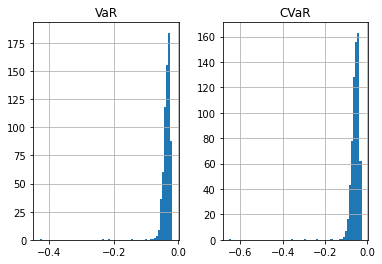

In [36]:
var_df.hist(bins=64)

In [39]:
var_df.describe()

,VaR,CVaR
count,662.000000,662.000000
mean,-0.036593,-0.058620
std,0.021534,0.032716
min,-0.429304,-0.652923
25%,-0.041210,-0.066427
50%,-0.033610,-0.054436
75%,-0.027516,-0.044748
max,-0.018561,-0.028259


# Export result

In [37]:
selected_pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR
160,ICE,ZBRA,0.999990,4267,0.921816,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,Zebra Technologies Corporation,Technology,Communication Equipment,False,False,-0.307507,1.246738,-4171.347385,-15206.826017,547.383064,0.422320,0.544870,-0.032960,-0.058654,-0.033591,-0.054747
161,JNPR,TPR,0.999990,5551,-0.123542,"Juniper Networks, Inc.",Technology,Communication Equipment,"Tapestry, Inc.",Consumer Cyclical,Luxury Goods,False,False,2.893194,0.140865,463.511463,3794.351841,1176.724157,0.528819,0.499346,-0.049623,-0.077658,-0.038379,-0.062078
162,MBI,LULU,0.999989,3843,-0.027899,MBIA Inc.,Financial Services,Insurance—Specialty,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,False,False,2.896420,0.563837,1972.747682,-2752.406489,910.641747,0.511336,0.438883,-0.048364,-0.084237,-0.044949,-0.073931
163,EBAY,LSI,0.999989,6065,0.914633,eBay Inc.,Consumer Cyclical,Internet Retail,"Life Storage, Inc.",Real Estate,REIT—Industrial,False,False,1.496467,0.739130,29832.125027,-2830.423523,1121.945354,0.494545,0.429923,-0.040757,-0.069210,-0.024821,-0.042188
164,JPM,WTW,0.999989,5381,0.948272,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,Willis Towers Watson Public Limited Company,Financial Services,Insurance Brokers,True,False,2.095041,0.652963,-13438.627734,-4997.649075,699.759923,0.478669,0.377684,-0.034680,-0.054405,-0.023175,-0.038785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,BWA,LBTYK,0.950007,4316,0.875707,BorgWarner Inc.,Consumer Cyclical,Auto Parts,Liberty Global plc,Communication Services,Telecom Services,False,False,-0.179080,0.947352,8348.932040,5960.763182,657.721274,0.475160,0.451980,-0.034694,-0.052044,-0.030287,-0.049510
22691,LIN,SO,0.950006,6248,0.923458,Linde plc,Basic Materials,Specialty Chemicals,The Southern Company,Utilities,Utilities—Regulated Electric,False,False,1.562967,0.467798,-2129.422834,-6322.536823,704.915707,0.394240,0.361833,-0.026850,-0.039937,-0.019140,-0.030212
22692,KR,PPG,0.950005,6248,0.901057,The Kroger Co.,Consumer Defensive,Grocery Stores,"PPG Industries, Inc.",Basic Materials,Specialty Chemicals,False,False,0.882089,1.095208,-4207.621220,-16711.488530,8431.579082,0.442471,0.479466,-0.027641,-0.044010,-0.027124,-0.040719
22693,DHI,ETSY,0.950004,1900,0.925374,"D.R. Horton, Inc.",Consumer Cyclical,Residential Construction,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False,-5.481609,2.388161,-5170.915493,1319.830553,797.320137,0.461235,0.532347,-0.042125,-0.063906,-0.056610,-0.086710


In [38]:
selected_pair_df.to_csv('analysis/pairs.csv', index=False)